# Grain Boundary Segregation Workflow

This notebook demonstrates a complete workflow for studying grain boundary (GB) segregation in materials using pyiron_workflow_atomistics using the LAMMPS calculation engine.

## Overview

The workflow consists of the following main steps:
1. **Lattice Optimization**: Optimize the bulk lattice parameter
2. **Solution Energy**: Calculate the solution energy of a solute in bulk
3. **GB Search**: Find suitable grain boundary structures
4. **Pure GB Study**: Analyze the pure grain boundary properties
5. **Segregation Study**: Calculate segregation energies at GB sites

## Imports

First, we import all necessary libraries and modules.


In [1]:
import os
from typing import Union, Optional, Tuple

import numpy as np
import pandas as pd

# ASE imports
from ase.build import bulk, stack
from ase.lattice.cubic import BodyCenteredCubic as bcc

# Pyiron workflow imports
import pyiron_workflow as pwf
from pyiron_workflow import Workflow
from pyiron_workflow_atomistics.dataclass_storage import CalcInputMinimize
from pyiron_workflow_atomistics.bulk import optimise_cubic_lattice_parameter
from pyiron_workflow_lammps.engine import LammpsEngine
from pyiron_workflow_atomistics.structure_manipulator.tools import create_supercell, create_supercell_with_min_dimensions
from pyiron_workflow_atomistics.structure_manipulator.tools import substitutional_swap_one_site

from pyiron_workflow_atomistics.gb.gb_code.searcher import get_gb_code_df_with_structures
from pyiron_workflow_atomistics.calculator import calculate_structure_node
# Pymatgen imports
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor

%load_ext autoreload
%autoreload 2

## Verify Installation

Let's verify that the pyiron_workflow_atomistics package is correctly installed and accessible.


In [2]:
import pyiron_workflow_atomistics
print(pyiron_workflow_atomistics.__file__)

/root/github_dev/pyiron_workflow_atomistics/pyiron_workflow_atomistics/__init__.py


# Step 1: Workflow Definition and Lattice Optimization

In this step, we:
1. **Initialize the workflow** with a name and clean workspace
2. **Create the initial structure** using ASE's bulk builder for Fe (BCC)
3. **Setup the LAMMPS calculation engine** with:
   - EAM/FS potential for Al-Fe system
   - Minimization settings (no cell relaxation)
   - Working directory structure
4. **Optimize the lattice parameter** by:
   - Applying small strains to the structure
   - Calculating energies at each strain
   - Fitting an equation of state (Birch-Murnaghan)
   - Extracting the equilibrium lattice parameter

This gives us the relaxed bulk structure with the optimal lattice parameter for subsequent calculations.


In [3]:
wf = Workflow("gb_segregation", delete_existing_savefiles=True)
structure = bulk("Fe", a=2.85, cubic=True)

# Engine definition - minimization for structure relaxation
inp = CalcInputMinimize()
inp.relax_cell = False  # Don't relax the cell
Engine = LammpsEngine(EngineInput=inp)
Engine.working_directory = "gb_segregation"
Engine.lammps_log_filepath = "minimize.log"
Engine.command = "lmp -in in.lmp -log minimize.log"
Engine.input_script_pair_style = "eam/fs"
potential_path = os.getcwd() + "/Al-Fe.eam.fs"
Engine.path_to_model = potential_path

os.makedirs("calculations", exist_ok=True)
os.chdir("calculations")
# Optimize the cubic lattice parameter
wf.opt_cubic_cell = optimise_cubic_lattice_parameter(
    structure=structure,
    name="Fe",
    crystalstructure="bcc",
    calculation_engine=Engine,
    parent_working_directory="opt_cubic_cell",
    rattle=0.1,
    strain_range=(-0.02, 0.02),
    num_points=10,
    eos_type="birchmurnaghan",
)

# Step 2: Solution Energy Calculation

The solution energy tells us how favorable it is to dissolve a solute atom (Al) into the bulk host material (Fe).

In this step, we:
1. **Create a large supercell** (12×12×12 Å minimum dimensions) to avoid spurious interactions between periodic images of the solute
2. **Calculate the energy of pure bulk** supercell
3. **Create a supercell with one Al solute** by substituting one Fe atom at position 0
4. **Calculate the energy with the solute** present
5. **Compute the solution energy** as: E_solution = E_with_solute - E_pure_bulk

A positive solution energy indicates that dissolving Al in Fe is energetically unfavorable in the bulk.

This value will be used later to calculate segregation energies at grain boundaries.


In [4]:
from pyiron_workflow_atomistics.utils import duplicate_engine

# Create duplicate engines for bulk calculations
Engine_bulk = duplicate_engine.node_function(Engine, "solution_energy_bulk")
Engine_bulk.working_directory = "solution_energy_bulk"

# Create supercell to avoid solute-solute interactions
wf.supercell = create_supercell_with_min_dimensions(
    base_structure=wf.opt_cubic_cell.outputs.equil_struct,
    min_dimensions=[12, 12, 12],
)
wf.supercell_calc = calculate_structure_node(wf.supercell, calculation_engine=Engine_bulk)

# Create supercell with solute (Fe -> Al substitution)
Engine_bulk_solute = duplicate_engine.node_function(Engine, "solution_energy_solute")
Engine_bulk_solute.working_directory = "solution_energy_solute"

wf.supercell_with_1sol = substitutional_swap_one_site(
    base_structure=wf.supercell,
    defect_site=0,
    new_symbol="Al",
)
wf.supercell_with_1sol_calc = calculate_structure_node(
    structure=wf.supercell_with_1sol,
    calculation_engine=Engine_bulk_solute,
)

# Calculate solution energy
@pwf.as_function_node("solution_energy")
def calculate_soln_energy(bulk_structure_energy, soln_structure_energy):
    return soln_structure_energy - bulk_structure_energy

wf.soln_energy = calculate_soln_energy(
    bulk_structure_energy=wf.supercell_calc.outputs.calc_output.final_energy,
    soln_structure_energy=wf.supercell_with_1sol_calc.outputs.calc_output.final_energy,
)


# Step 3: Grain Boundary Search

Now we search for suitable grain boundary structures using the GBCode algorithm.

In this step, we:
1. **Search for CSL (Coincidence Site Lattice) grain boundaries** along three different crystallographic axes: [111], [110], and [100]
2. **Filter structures** based on:
   - Sigma values (up to Σ10)
   - Maximum number of atoms (≤100)
   - Minimum grain dimensions (10 Å in-plane, 15 Å along grain)
3. **Generate atomistic structures** for each valid GB configuration
4. **Remove duplicates** to get a unique set of GB structures

The output is a DataFrame containing various GB structures with different misorientations, planes, and atomic arrangements.

For this workflow, we'll select the first GB structure from the results for detailed analysis.


In [5]:
# Search GBCode for valid CSL GB structures
wf.gb_code_df = get_gb_code_df_with_structures(
    axes_list=[np.array([1, 1, 1]), np.array([1, 1, 0]), np.array([1, 0, 0])],
    sigma_limit=10,
    lim_plane_index=3,
    max_atoms=100,
    max_workers=None,
    deduplicate=True,
    element="Fe",
    basis="bcc",
    lattice_param=wf.opt_cubic_cell.outputs.a0,
    equil_volume_per_atom=wf.opt_cubic_cell.outputs.equil_volume_per_atom,
    min_inplane_gb_length=10,
    req_length_grain=15,
    grain_length_axis=0,
)


# Step 4: Pure Grain Boundary Study

This comprehensive step analyzes the properties of the pure (undecorated) grain boundary.

The workflow performs:

## 4.1 GB Plane Identification
- Uses **Voronoi site featurization** to identify atomic environments
- Compares GB region atoms to bulk templates
- Locates the GB plane position automatically

## 4.2 Grain Length Optimization
- **Stage 1**: Coarse scan over large extension range (-0.2 to 0.8 Å)
- **Stage 2**: Fine scan around minima (-0.05 to 0.05 Å)
- Finds the optimal grain extension that minimizes GB energy

## 4.3 Cleavage Energy Calculation
- Identifies viable cleavage planes near the GB
- Calculates **rigid cleavage energy** (static calculations)
- Calculates **relaxed cleavage energy** (with atomic relaxation)
- Both contribute to understanding GB cohesion

## 4.4 Structure Preparation
- Adds vacuum layer (20 Å) for surface calculations
- Expands cell to minimum dimensions (6×6 Å in-plane)
- Prepares the final GB structure for segregation studies

**Output**: Optimized pure GB structure with known GB plane location, GB energy, and cleavage properties.


In [6]:
from pyiron_workflow_atomistics.dataclass_storage import CalcInputStatic
from pyiron_workflow_atomistics.gb.gb_study import pure_gb_study
from pyiron_workflow_atomistics.gb.dataclass_storage import CleaveGBStructureInput, PlotCleaveInput
from pyiron_workflow_atomistics.featurisers import voronoiSiteFeaturiser

# Create engines for GB study
Engine_gb = duplicate_engine.node_function(Engine, "gb_study")
Engine_gb.working_directory = "gb_study"

# Static engine for cleavage energy calculations
inp_static = CalcInputStatic()
Engine_static = LammpsEngine(EngineInput=inp_static)
Engine_static.working_directory = "pure_grain_boundary_study"
Engine_static.lammps_log_filepath = "static.log"
Engine_static.command = "lmp -in in.lmp -log static.log"
Engine_static.input_script_pair_style = "eam/fs"
Engine_static.path_to_model = potential_path

# Run pure GB study
wf.pure_gb_study = pure_gb_study(
    gb_structure=wf.gb_code_df.outputs.gb_code_df_with_structures.iloc[0].structure,
    equil_bulk_volume=wf.opt_cubic_cell.outputs.equil_volume_per_atom,
    equil_bulk_energy=wf.opt_cubic_cell.outputs.equil_energy_per_atom,
    extensions_stage1=np.linspace(-0.2, 0.8, 3),
    extensions_stage2=np.linspace(-0.05, 0.05, 5),
    calculation_engine=Engine_gb,
    static_calculation_engine=Engine_static,
    length_interpolate_min_n_points=5,
    gb_normal_axis="c",
    vacuum_length=20,
    min_inplane_cell_lengths=[6, 6, None],
    featuriser=voronoiSiteFeaturiser,
    approx_frac=0.5,
    tolerance=5.0,
    bulk_offset=10.0,
    slab_thickness=2.0,
    featuriser_kwargs=None,
    n_bulk=10,
    threshold_frac=0.3,
    CleaveGBStructure_Input=CleaveGBStructureInput(tol=0.3),
    PlotCleave_Input=PlotCleaveInput()
)


# Step 5: Segregation Study

This is the main segregation calculation where we determine which GB sites are energetically favorable for Al segregation.

## 5.1 Site Identification and Deduplication
We use **SOAP (Smooth Overlap of Atomic Positions)** descriptors to:
- Characterize the local atomic environment around each GB site
- Apply PCA (Principal Component Analysis) for dimensionality reduction
- Group sites with similar environments (similarity > 99.999%)
- Select representative sites from each unique environment

This dramatically reduces computational cost by avoiding redundant calculations on symmetrically equivalent sites.

## 5.2 Segregation Energy Calculations
For each unique site, we:
1. **Create a structure** with Al substituted at that site
2. **Calculate the total energy** using LAMMPS
3. **Compute segregation energy** as:
   
   E_seg = (E_GB+Al - E_GB_pure) - E_solution
   
   where:
   - E_GB+Al = energy of GB with Al at the site
   - E_GB_pure = energy of pure GB
   - E_solution = bulk solution energy (from Step 2)

**Interpretation**:
- **Negative E_seg**: Segregation is favorable (Al prefers GB over bulk)
- **Positive E_seg**: Segregation is unfavorable (Al prefers bulk)

The magnitude indicates the strength of the segregation tendency.


In [7]:
from pyiron_workflow_atomistics.gb.segregation import calculate_substitutional_segregation_GB, get_unique_sites_SOAP

# Identify unique sites using SOAP descriptors
wf.site_duplicate_df = get_unique_sites_SOAP(
    structure=wf.pure_gb_study.outputs.pure_grain_boundary_structure_vacuum,
    defect_sites=wf.pure_gb_study.outputs.gb_plane_analysis_dict["extended_sel_indices"],
    r_cut=6.0,
    n_max=10,
    l_max=10,
    n_jobs=-1,
    periodic=True,
    pca_variance_threshold=0.999,
    similarity_threshold=0.99999
)

# Create engine for segregation calculations
Engine_segregation = duplicate_engine.node_function(Engine, "segregation_study")
Engine_segregation.working_directory = "segregation_study"

# Calculate substitutional segregation energies
wf.gb_seg_calcs = calculate_substitutional_segregation_GB(
    structure=wf.pure_gb_study.outputs.pure_grain_boundary_structure_vacuum,
    defect_sites=wf.site_duplicate_df.outputs.unique_sites_list,
    element="Al",
    structure_basename="pureGB_Fe_seg",
    parent_dir="gb_seg_lammps",
    calculation_engine=Engine_segregation,
    unique_sites_df=wf.site_duplicate_df.outputs.df,
    df_filename="seg_calcs_df.pkl",
)


# Workflow Execution

Now we execute the complete workflow. 

1. Executes all nodes that can be computed with available inputs

**Expected Output**:
- Progress bars for GB structure generation
- LAMMPS calculation logs
- Status messages for each workflow stage

**Execution Time**: This may take several minutes to hours depending on:
- Number of GB structures found
- Number of unique segregation sites
- Computational resources available
- Type of engine used (eam potential/ml potential/)


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.12/site-packages/pyiron_workflow_lammps/engine.py:116: RuntimeWarning: 'mode' already set to 'minimize' and also implied by EngineInput; no change.
  warnings.warn(
2025-11-03 20:24:32,713 - pyiron_log - WARNING - Directory 'gb_segregation/strain_000' already exists. Existing files may be overwritten.


current mode  minimize


2025-11-03 20:24:34,382 - pyiron_log - WARNING - Directory 'gb_segregation/strain_001' already exists. Existing files may be overwritten.
2025-11-03 20:24:36,016 - pyiron_log - WARNING - Directory 'gb_segregation/strain_002' already exists. Existing files may be overwritten.
2025-11-03 20:24:37,672 - pyiron_log - WARNING - Directory 'gb_segregation/strain_003' already exists. Existing files may be overwritten.
2025-11-03 20:24:39,378 - pyiron_log - WARNING - Directory 'gb_segregation/strain_004' already exists. Existing files may be overwritten.
2025-11-03 20:24:41,006 - pyiron_log - WARNING - Directory 'gb_segregation/strain_005' already exists. Existing files may be overwritten.
2025-11-03 20:24:42,738 - pyiron_log - WARNING - Directory 'gb_segregation/strain_006' already exists. Existing files may be overwritten.
2025-11-03 20:24:44,321 - pyiron_log - WARNING - Directory 'gb_segregation/strain_007' already exists. Existing files may be overwritten.
2025-11-03 20:24:45,906 - pyiron_l

current mode  minimize


2025-11-03 20:25:58,212 - pyiron_log - WARNING - Directory 'solution_energy_solute' already exists. Existing files may be overwritten.


current mode  minimize


2025-11-03 20:25:59,934 - pyiron_log - WARNING - Directory 'gb_study/gb_length_optimiser/ext_0.800' already exists. Existing files may be overwritten.


current mode  static
current mode  minimize


2025-11-03 20:26:01,640 - pyiron_log - WARNING - Directory 'gb_study/gb_length_optimiser/ext_0.300' already exists. Existing files may be overwritten.
2025-11-03 20:26:03,342 - pyiron_log - WARNING - Directory 'gb_study/gb_length_optimiser/ext_-0.200' already exists. Existing files may be overwritten.
2025-11-03 20:26:05,258 - pyiron_log - WARNING - Directory 'gb_study/gb_length_optimiser/ext_0.050' already exists. Existing files may be overwritten.
2025-11-03 20:26:06,954 - pyiron_log - WARNING - Directory 'gb_study/gb_length_optimiser/ext_0.025' already exists. Existing files may be overwritten.
2025-11-03 20:26:08,620 - pyiron_log - WARNING - Directory 'gb_study/gb_length_optimiser/ext_0.000' already exists. Existing files may be overwritten.
2025-11-03 20:26:10,284 - pyiron_log - WARNING - Directory 'gb_study/gb_length_optimiser/ext_-0.025' already exists. Existing files may be overwritten.
2025-11-03 20:26:12,072 - pyiron_log - WARNING - Directory 'gb_study/gb_length_optimiser/ext

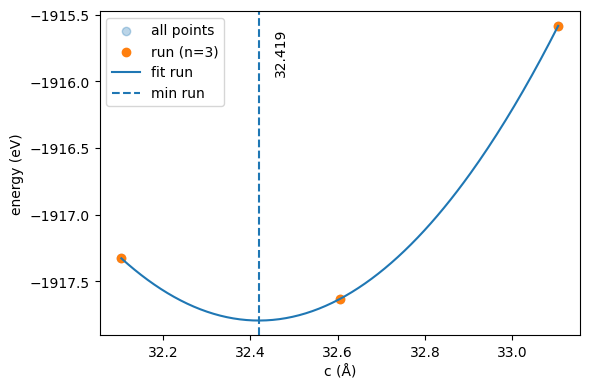

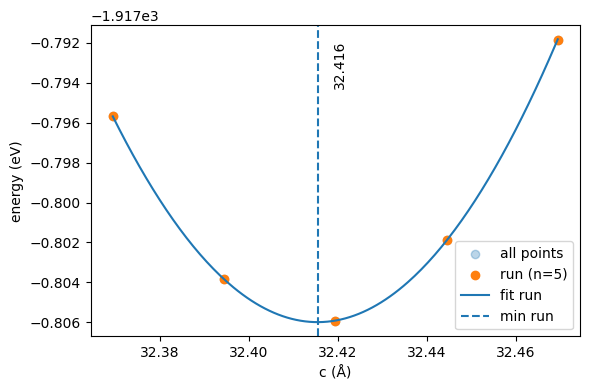

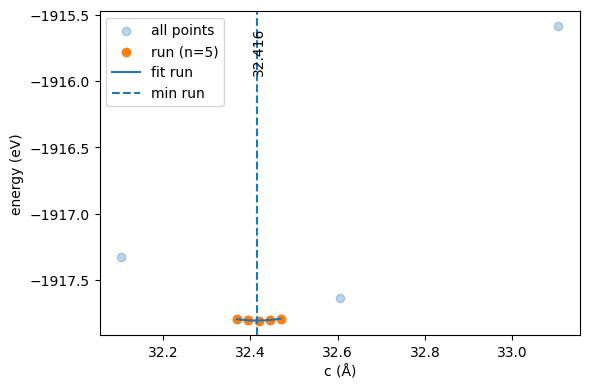

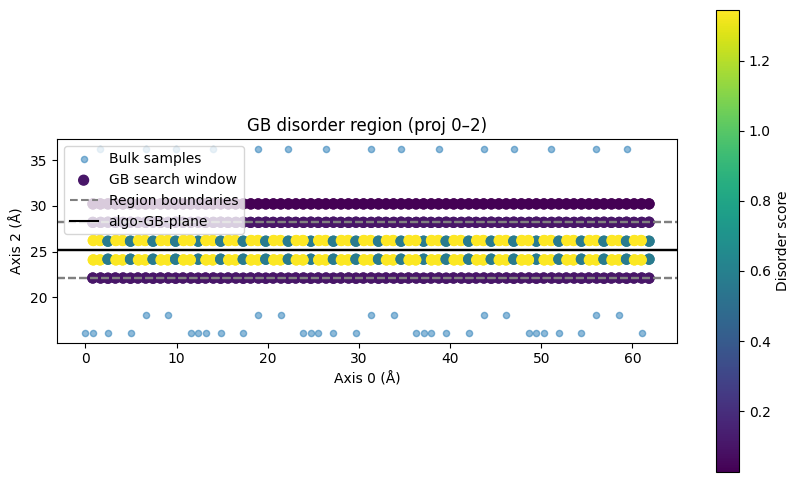

2025-11-03 20:26:28,494 - pyiron_log - WARNING - Directory 'gb_study/gb_seg_supercell' already exists. Existing files may be overwritten.
2025-11-03 20:26:30,376 - pyiron_log - WARNING - Directory 'pure_grain_boundary_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_27.165' already exists. Existing files may be overwritten.
2025-11-03 20:26:32,031 - pyiron_log - WARNING - Directory 'pure_grain_boundary_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_25.108' already exists. Existing files may be overwritten.
2025-11-03 20:26:33,700 - pyiron_log - WARNING - Directory 'pure_grain_boundary_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_23.078' already exists. Existing files may be overwritten.
2025-11-03 20:26:35,354 - pyiron_log - WARNING - Directory 'pure_grain_boundary_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_21.07' already exists. Existing files may be overwritten.
2025-11-03 20:26:37,158 - pyiron_log - WARNING - Directory 'gb_study/cleavage_study/cleavag

current mode  minimize
current mode  minimize
current mode  minimize
current mode  minimize
current mode  minimize
current mode  minimize
current mode  minimize
current mode  minimize
current mode  minimize
current mode  minimize


{'opt_cubic_cell__B': 177.0390163507032,
 'opt_cubic_cell__volumes': [21.787771257000003,
  22.08554991529631,
  22.386029495370348,
  22.689222191000006,
  22.99514019596296,
  23.303795704037036,
  23.615200909,
  23.92936800462963,
  24.24630918470369,
  24.56603664300001],
 'opt_cubic_cell__structures': [Atoms(symbols='Fe2', pbc=True, cell=[[2.7929999999999997, 1.7102192550092785e-16, 1.7102192550092785e-16], [0.0, 2.7929999999999997, 1.7102192550092785e-16], [0.0, 0.0, 2.7929999999999997]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.805666666666667, 1.717975351403879e-16, 1.717975351403879e-16], [0.0, 2.805666666666667, 1.717975351403879e-16], [0.0, 0.0, 2.805666666666667]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.8183333333333325, 1.7257314477984784e-16, 1.7257314477984784e-16], [0.0, 2.8183333333333325, 1.7257314477984784e-16], [0.0, 0.0, 2.8183333333333325]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.831, 1.7334875441930788e-16, 1.7334875441930788e-16], [0.0, 2.831, 1.73348

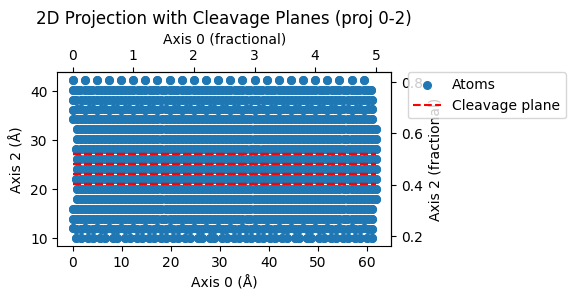

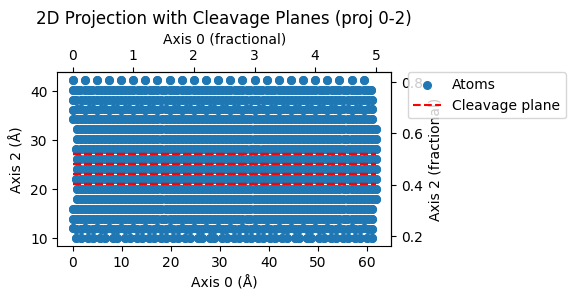

In [8]:
wf.run()

# Results Analysis

Now that the workflow has completed, let's analyze the segregation results.

## Data Processing

We will:
1. **Extract energies** from the calculation outputs
2. **Calculate segregation energies** for each site using:
   - E_seg = (E_GB+Al - E_GB_pure) - E_solution
3. **Compute the distance** of each site from the GB plane
4. **Organize results** in a DataFrame for easy analysis

This will allow us to:
- Identify which sites have the strongest segregation tendency
- Understand how segregation energy varies with distance from the GB plane
- Visualize the relationship between atomic position and segregation behavior


In [9]:
df = wf.gb_seg_calcs.outputs.gb_seg_calcs_df.value.copy()
df["energy"] = df.calc_output.apply(lambda x: x.final_energy)
df["Eseg"] = (
    df.energy
    - wf.pure_gb_study.outputs.pure_grain_boundary_structure_vacuum_energy.value
    - wf.soln_energy.outputs.solution_energy.value
)

import numpy as np

gb_pos = wf.pure_gb_study.outputs.gb_plane_analysis_dict.value["gb_cart"]

# Fix: positions might be a 2D array for each structure;
# make sure to use correct slicing and avoid invalid index to scalar variable errors.
def get_site_gb_distance(row):
    struct = row["structure"]
    rep_idx = row["rep"]
    print(struct.positions[rep_idx])
    dist = np.round(np.abs(struct.positions[rep_idx][2] - gb_pos), 1)
    return dist

df["dist_GB"] = df.apply(get_site_gb_distance, axis=1)

df.sort_values(by="dist_GB")

[ 0.80888633  2.34192561 22.09412539]
[1.23640718e+01 1.66503578e-09 2.20746117e+01]
[12.36407185  3.49708762 24.1575707 ]
[ 1.60845649  1.15645055 24.08180249]
[1.23640718e+01 1.66503578e-09 2.61334940e+01]
[ 1.6083699   2.34060187 26.20893309]
[ 1.66357445  5.83882417 28.19658341]
[12.36407185  3.49708762 28.21597435]
[1.23640718e+01 1.66821636e-09 3.02244994e+01]
[ 1.64236785  2.32760124 30.22201023]


,rep,same,structure,calc_output,energy,Eseg,dist_GB
2,21,"[69, 117, 165, 213, 261, 309, 357, 405, 453]","(Atom('Fe', [1.1245057839914804e-11, 1.6618544...","EngineOutput(\n convergence=True,\n energies...",-1875.894196,-0.014731,1.0
4,24,"[72, 120, 168, 216, 264, 312, 360, 408, 456]","(Atom('Fe', [1.1245057839914804e-11, 1.6618544...","EngineOutput(\n convergence=True,\n energies...",-1875.894172,-0.014707,1.0
3,22,"[23, 70, 71, 118, 119, 166, 167, 214, 215, 262...","(Atom('Fe', [1.1245057839914804e-11, 1.6618544...","EngineOutput(\n convergence=True,\n energies...",-1876.831684,-0.952218,1.1
5,25,"[26, 73, 74, 121, 122, 169, 170, 217, 218, 265...","(Atom('Fe', [1.1245057839914804e-11, 1.6618544...","EngineOutput(\n convergence=True,\n energies...",-1876.831753,-0.952288,1.1
0,18,"[20, 66, 68, 114, 116, 162, 164, 210, 212, 258...","(Atom('Fe', [1.1245057839914804e-11, 1.6618544...","EngineOutput(\n convergence=True,\n energies...",-1876.803523,-0.924058,3.1
1,19,"[67, 115, 163, 211, 259, 307, 355, 403, 451]","(Atom('Fe', [1.1245057839914804e-11, 1.6618544...","EngineOutput(\n convergence=True,\n energies...",-1875.895463,-0.015998,3.1
6,27,"[29, 75, 77, 123, 125, 171, 173, 219, 221, 267...","(Atom('Fe', [1.1245057839914804e-11, 1.6618544...","EngineOutput(\n convergence=True,\n energies...",-1876.803440,-0.923975,3.1
7,28,"[76, 124, 172, 220, 268, 316, 364, 412, 460]","(Atom('Fe', [1.1245057839914804e-11, 1.6618544...","EngineOutput(\n convergence=True,\n energies...",-1875.895489,-0.016024,3.1
8,30,"[78, 126, 174, 222, 270, 318, 366, 414, 462]","(Atom('Fe', [1.1245057839914804e-11, 1.6618544...","EngineOutput(\n convergence=True,\n energies...",-1875.877653,0.001812,5.1
9,31,"[32, 79, 80, 127, 128, 175, 176, 223, 224, 271...","(Atom('Fe', [1.1245057839914804e-11, 1.6618544...","EngineOutput(\n convergence=True,\n energies...",-1875.882359,-0.002894,5.1


In [12]:
os.chdir("..")
import shutil
shutil.rmtree("calculations", ignore_errors=True)